# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


### Initialize Libraries

In [1]:
import netCDF4 as nc4;        import pandas as pd
import requests;              import json;
import matplotlib as mpl;     import matplotlib.pyplot as plt
import matplotlib.tri as tri; import pathlib as pl
import cartopy.crs as ccrs;   import cartopy.io.img_tiles as cart_img
import cartopy as cart;       import cartopy.io.img_tiles as cimgt
import numpy as np;           import wse
import skill_metrics as sm;   import geopandas as gpd
import calendar;              


from shapely import Polygon,Point,MultiPoint,LineString,MultiLineString;import shapely.vectorized
from scipy.stats import linregress
from sklearn.metrics import root_mean_squared_error


salloc --ntasks=40 --nodes=1 --partition=normal --mem-per-cpu=8GB --time=06:00:00

source $HOME/miniforge3/bin/activate

### Defined Functions

#### Data for this exercise can be found here
https://doi.org/10.17603/ds2-h0fw-2p96

Download the swan_HS.63.nc from one of the 4 folders

---

### Initialize path and read netcdf file

In [2]:
root = pl.Path('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database/Raw_DATA')

#ncfile = nc4.Dataset(root / '2023' /'outputs' / 'fort.63.nc')

#### Read metadata within netcdf file

_____________________________________

In [3]:
stations = {'prudhoe':{'id':9497645,'lat':70.421459,'lon':-148.546311},
            'red':{'id':9491094,'lat':67.573681,'lon':-164.070663},
            'nome':{'id':9468756,'lat':64.499170,'lon':-165.431689},
            'unalakleet':{'id':9468333,'lat':63.881322,'lon':-160.820145},
            'paul':{'id':9464212,'lat':57.228635,'lon':-170.241801}}


In [32]:
name = 'nome'
df_noaa_daily = pd.read_csv(f'/scratch/tmiesse/project/noaa_data/{name}_mhhw.csv')
df_hourly_wse = pd.read_csv(f'/scratch/tmiesse/project/model_data/{name}_model_hourly_wse.csv')
df_hourly_wse["dt"] = pd.to_datetime(df_hourly_wse["dt"], errors="coerce")
df_hourly_wse["data"] = pd.to_numeric(df_hourly_wse["data"], errors="coerce")
df_hourly_wse = df_hourly_wse.dropna(subset=["dt", "data"]).copy()

# Extract the daily max WSE with exact timestamp preserved
df_model_daily = (
    df_hourly_wse
    .set_index("dt")
    .resample("D")["data"]
    .max()
    .reset_index()
)
years = ['2024','2023','2022','2021','2020','2019',
         '2018','2017','2016','2015','2014','2013',
         '2012','2011','2010']

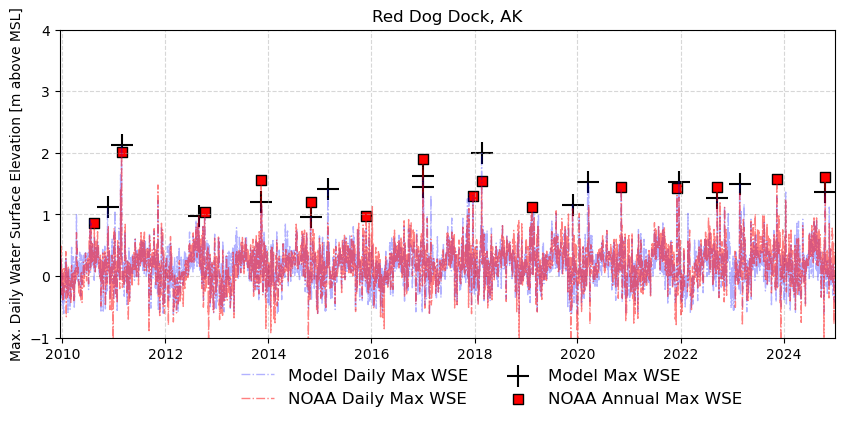

In [10]:

df_model_daily["Date"] = pd.to_datetime(df_model_daily["dt"]).dt.date  # Convert to date
df_model_daily["Date"] = pd.to_datetime(df_model_daily["Date"])  # Ensure it's in datetime64
df_model_daily = df_model_daily.sort_values(by="Date").reset_index(drop=True)
df_noaa_daily["Date"] = pd.to_datetime(df_noaa_daily["Date"]) 
df_noaa_daily["Year"] = pd.to_datetime(df_noaa_daily["Date"]).dt.year

fig, ax = plt.subplots(figsize=(10, 4))
# Plot Model Daily Max WSE
ax.plot(pd.to_datetime(df_model_daily["Date"]), df_model_daily["data"], linestyle='-.',lw=1,
        color="blue", alpha=0.3, label="Model Daily Max WSE")# if year == int(years[0]) else "")

# Plot NOAA Daily Max WSE
ax.plot(pd.to_datetime(df_noaa_daily["Date"]), df_noaa_daily["v"], linestyle='-.',lw=1,
        color="red", alpha=0.5, label="NOAA Daily Max WSE")# if year == int(years[0]) else "")

for year in years:
    # **Model Annual Max Extraction**
    idy_model = df_model_daily.loc[df_model_daily['Date'].dt.year == int(year)]
    if not idy_model.empty:
        ids_model = np.where(df_model_daily['data'].values == np.max(df_model_daily['data'][idy_model.index]))[0]
        ax.scatter(df_model_daily["Date"][ids_model], df_model_daily["data"][ids_model], 
                   color="k", marker="+", s=250, label="Model Max WSE" if year == years[0] else "")

    # **NOAA Annual Max Extraction**
    idy_noaa = df_noaa_daily.loc[df_noaa_daily['Date'].dt.year == int(year)]
    if not idy_noaa.empty:
        ids_noaa = np.where(df_noaa_daily['v'].values == np.max(df_noaa_daily['v'][idy_noaa.index]))[0]
        ax.scatter(df_noaa_daily["Date"][ids_noaa], df_noaa_daily["v"][ids_noaa], 
                   color="red", marker="s", s=50, label="NOAA Annual Max WSE" if year == years[0] else "", edgecolors="black")

ax.set_ylabel("Max. Daily Water Surface Elevation [m above MSL]")
ax.set_ylim([-1,4])
ax.set_xlim([pd.to_datetime(df_model_daily["Date"].min()), pd.to_datetime(df_model_daily["Date"].max())])
ax.set_title(f"{name.capitalize()} Dog Dock, AK")#{name.capitalize()},
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend(loc='upper right', bbox_to_anchor=(.9, -0.05), ncol=2, frameon=False, fontsize=12)
plt.savefig(f'/scratch/tmiesse/project/figures/{name}_daily_max_model_vs_noaa_scatter.png', 
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)

plt.show()

In [22]:
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions - targets)**2))

In [17]:
df_noaa = df_noaa_daily.copy()
df_noaa["t"] = pd.to_datetime(df_noaa["Date"])
df_noaa["Date"] = pd.to_datetime(df_noaa["Date"], errors="coerce")
df_noaa["v"] = pd.to_numeric(df_noaa["v"], errors="coerce")
df_noaa_clean = df_noaa.dropna(subset=["t", "v"]).copy()
df_noaa_clean["date"] = df_noaa_clean["t"].dt.date

daily_max_values = df_noaa_clean.groupby("date")["v"].max().reset_index()
daily_max_values.rename(columns={"v": "NOAA Max WSE"}, inplace=True)
df_noaa = df_noaa_daily.copy()
df_noaa["t"] = pd.to_datetime(df_noaa["Date"])
df_noaa["v"] = pd.to_numeric(df_noaa["v"], errors="coerce")
df_noaa = df_noaa.dropna(subset=["v"])

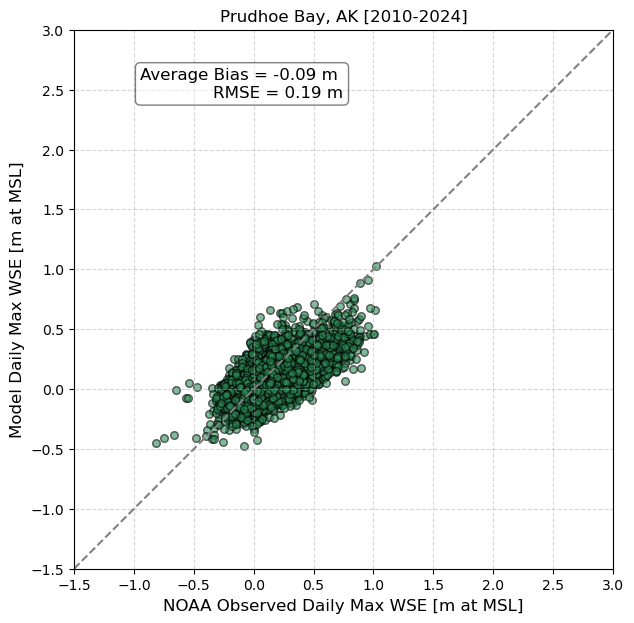

In [18]:
df_noaa["Date"] = pd.to_datetime(df_noaa["Date"], errors="coerce")
df_noaa_daily_exact = (
    df_noaa
    .groupby(df_noaa["Date"].dt.date)
    .apply(lambda x: x.loc[x["v"].idxmax()])
    .reset_index(drop=True)
    .rename(columns={"Date": "dt", "v": "NOAA Max WSE"})
)

# Model: same idea — max per day with exact datetime preserved
#df_model_daily["dt"] = pd.to_datetime(df_model_daily["dt"], errors="coerce")
#df_model_daily["data"] = pd.to_numeric(df_model_daily["data"], errors="coerce")

# Drop rows where model WSE is missing
df_model_daily_clean = df_model_daily.dropna(subset=["dt", "data"]).copy()

# Now safely extract the daily max values with exact timestamps
df_model_daily_exact = (
    df_model_daily_clean
    .groupby(df_model_daily_clean["dt"].dt.date)
    .apply(lambda x: x.loc[x["data"].idxmax()])
    .reset_index(drop=True)
)
df_model_daily_exact["dt"] = pd.to_datetime(df_model_daily_exact["dt"], utc=True)
df_noaa_daily_exact["dt"] = pd.to_datetime(df_noaa_daily_exact["dt"], utc=True)
# Step 2: Merge on exact matching UTC datetimes
df_compare_exact = pd.merge(df_model_daily, df_noaa_daily_exact, on="dt", how="inner").dropna()
# --- Step 4: Create scatter plot with 1:1 line only ---
fig, ax = plt.subplots(figsize=(7, 7))

# steelblue nome
# darkorange red dog
# seagreen prudhoe 
# mediumorchid unalakleet

# Scatter plot
color = "seagreen"
ax.scatter(df_compare_exact["NOAA Max WSE"], df_compare_exact["data"],
           color=color, edgecolor="k", alpha=0.6, s=30) 
rmse_val = rmse(df_compare_exact["NOAA Max WSE"], df_compare_exact["data"])
mbias = np.mean(df_compare_exact["data"]-df_compare_exact["NOAA Max WSE"])
text = (f'Average Bias = {mbias:.2f} m \n'
        f'RMSE = {rmse_val:.2f} m')
bbox = dict(boxstyle='round', fc='white', ec='black', alpha=0.5)
ax.text(0.5,0.875,text,fontsize=12,transform=ax.transAxes, horizontalalignment='right',bbox=bbox)

lims = [-1.5, 3]
ax.plot(lims, lims, linestyle="--", color="gray")

# Labels and formatting
ax.set_xlabel("NOAA Observed Daily Max WSE [m at MSL]",fontsize=12)
ax.set_ylabel("Model Daily Max WSE [m at MSL]",fontsize=12)
ax.set_title(f"{name.capitalize()} Bay, AK [2010-2024]")
ax.set_xlim(lims),ax.set_ylim(lims)
ax.set_aspect('equal'),ax.grid(True, linestyle="--", alpha=0.5)
#plt.savefig(f'/scratch/tmiesse/project/figures/{name}_scatter2.png', 
#            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.show()

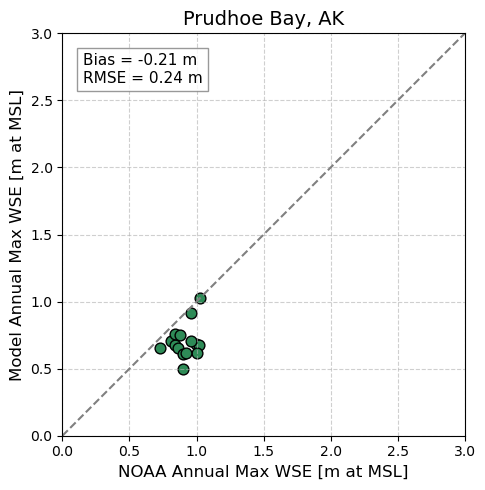

In [19]:
df_model_daily["Year"] = df_model_daily["dt"].dt.year
df_noaa_daily["Year"] = pd.to_datetime(df_noaa_daily["Date"]).dt.year
model_year_counts = df_model_daily["dt"].dt.date.groupby(df_model_daily["Year"]).nunique()
valid_model_years = model_year_counts[model_year_counts >= 364].index.tolist()

# Keep only complete years in model data
df_model_daily = df_model_daily[df_model_daily["Year"].isin(valid_model_years)]

# Optional: log dropped years
all_model_years = df_model_daily["Year"].unique()
excluded_years = set(model_year_counts.index) - set(valid_model_years)

model_annual_max = df_model_daily.groupby("Year")["data"].max().reset_index()
model_annual_max.rename(columns={"data": "Model Max WSE"}, inplace=True)

noaa_annual_max = df_noaa_daily.groupby("Year")["v"].max().reset_index()
noaa_annual_max.rename(columns={"v": "NOAA Max WSE"}, inplace=True)

# --- Step 4: Keep only years present in both datasets ---
common_years = sorted(set(model_annual_max["Year"]).intersection(noaa_annual_max["Year"]))
model_annual_max = model_annual_max[model_annual_max["Year"].isin(common_years)]
noaa_annual_max = noaa_annual_max[noaa_annual_max["Year"].isin(common_years)]

# --- Step 5: Merge the two datasets ---
df_annual_compare = pd.merge(model_annual_max, noaa_annual_max, on="Year", how="inner")


# --- Step 4: Optional error metrics ---
rmse_val = rmse(df_annual_compare["NOAA Max WSE"], df_annual_compare["Model Max WSE"])
bias_val = (df_annual_compare["Model Max WSE"] - df_annual_compare["NOAA Max WSE"]).mean()

# --- Step 5: Scatter Plot ---
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(df_annual_compare["NOAA Max WSE"], df_annual_compare["Model Max WSE"],
           color=color, edgecolor="black", s=60)

# 1:1 line
lims = [0,3]
ax.plot(lims, lims, linestyle="--", color="gray")

# Labels and stats
ax.set_xlabel("NOAA Annual Max WSE [m at MSL]", fontsize=12)
ax.set_ylabel("Model Annual Max WSE [m at MSL]", fontsize=12)
ax.set_title(f"{name.capitalize()} Bay, AK", fontsize=14)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect("equal")
ax.grid(True, linestyle="--", alpha=0.6)

# Annotate metrics
ax.text(0.05, 0.95,
        f"Bias = {bias_val:.2f} m\nRMSE = {rmse_val:.2f} m",
        transform=ax.transAxes, fontsize=11,
        bbox=dict(facecolor="white", edgecolor="gray", alpha=0.8),
        verticalalignment="top")

plt.tight_layout()
plt.savefig(f"/scratch/tmiesse/project/figures/{name}_annual_max_scatter.png", 
            dpi=480, bbox_inches="tight", pad_inches=0.1, transparent=False)
plt.show()

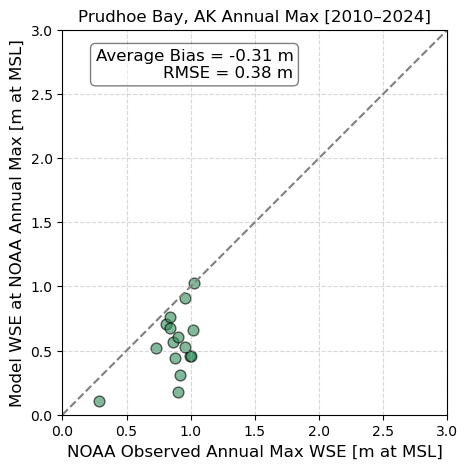

In [20]:
df_noaa_annual = df_compare_exact.loc[
    df_compare_exact.groupby(df_compare_exact["dt"].dt.year)["NOAA Max WSE"].idxmax()
].copy()

# Step 2: Extract matching model value at the same datetime (already present in df_compare_exact)
# This step is already implicitly done since df_compare_exact holds model and NOAA at same timestamp
# So we already have NOAA annual max AND corresponding model value

# Step 3: Plot the result
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(df_noaa_annual["NOAA Max WSE"], df_noaa_annual["data"],
           color=color, edgecolor="k", alpha=0.6, s=60)

# Error metrics
rmse_val = rmse(df_noaa_annual["NOAA Max WSE"], df_noaa_annual["data"])
mbias = (df_noaa_annual["data"] - df_noaa_annual["NOAA Max WSE"]).mean()

text = f"Average Bias = {mbias:.2f} m\nRMSE = {rmse_val:.2f} m"
bbox = dict(boxstyle='round', fc='white', ec='black', alpha=0.5)

ax.text(0.6, 0.875, text, fontsize=12, transform=ax.transAxes,
        horizontalalignment='right', bbox=bbox)

# 1:1 reference line
lims = [0, 3]
ax.plot(lims, lims, linestyle="--", color="gray")

# Labels and formatting
ax.set_xlabel("NOAA Observed Annual Max WSE [m at MSL]", fontsize=12)
ax.set_ylabel("Model WSE at NOAA Annual Max [m at MSL]", fontsize=12)
ax.set_title(f"{name.capitalize()} Bay, AK Annual Max [2010–2024]")
ax.set_xlim(lims), ax.set_ylim(lims)
ax.set_aspect('equal'), ax.grid(True, linestyle="--", alpha=0.5)

# Save and show
plt.savefig(f'/scratch/tmiesse/project/figures/{name}_annual_max_aligned_scatter.png',
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.show()

In [33]:
df_model_daily["Year"] = pd.to_datetime(df_model_daily["dt"]).dt.year
df_noaa_daily["Year"] = pd.to_datetime(df_noaa_daily["Date"]).dt.year
df_model_percentiles = (
    df_model_daily.groupby("Year")["data"]
    .quantile([0.95, 0.99])
    .unstack()
    .reset_index()
    .rename(columns={0.95: "Model 95th", 0.99: "Model 99th"})
)

# NOAA percentiles
df_noaa_percentiles = (
    df_noaa_daily.groupby("Year")["v"]
    .quantile([0.95, 0.99])
    .unstack()
    .reset_index()
    .rename(columns={0.95: "NOAA 95th", 0.99: "NOAA 99th"})
)
df_compare_percentiles = pd.merge(
    df_model_percentiles,
    df_noaa_percentiles,
    on="Year",
    how="inner"
)

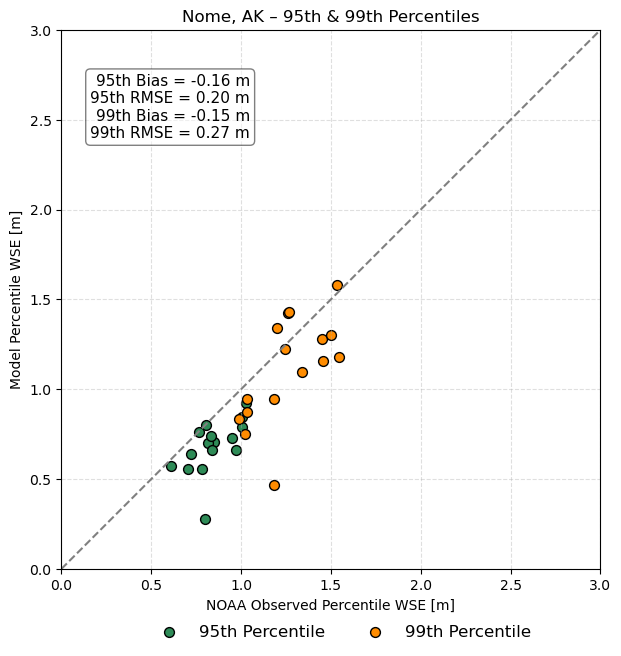

In [35]:

fig, ax = plt.subplots(figsize=(7, 7))

# Scatter for 95th
ax.scatter(df_compare_percentiles["NOAA 95th"], df_compare_percentiles["Model 95th"],
           label="95th Percentile", color="seagreen", edgecolor="k", s=50)

# Scatter for 99th
ax.scatter(df_compare_percentiles["NOAA 99th"], df_compare_percentiles["Model 99th"],
           label="99th Percentile", color="darkorange", edgecolor="k", s=50)

# 1:1 line
lims = [0, 3]
ax.plot(lims, lims, "--", color="gray")
rmse_95 = rmse(df_compare_percentiles["Model 95th"], df_compare_percentiles["NOAA 95th"])
bias_95 = np.mean(df_compare_percentiles["Model 95th"] - df_compare_percentiles["NOAA 95th"])

# 99th Percentile Comparison
rmse_99 = rmse(df_compare_percentiles["Model 99th"], df_compare_percentiles["NOAA 99th"])
bias_99 = np.mean(df_compare_percentiles["Model 99th"] - df_compare_percentiles["NOAA 99th"])
text = (
    f"95th Bias = {bias_95:.2f} m\n"
    f"95th RMSE = {rmse_95:.2f} m\n"
    f"99th Bias = {bias_99:.2f} m\n"
    f"99th RMSE = {rmse_99:.2f} m"
)

bbox = dict(boxstyle="round", fc="white", ec="black", alpha=0.5)
ax.text(0.35, 0.8, text, transform=ax.transAxes,
        fontsize=11, ha="right", bbox=bbox)
# Labels and styling
ax.set_xlabel("NOAA Observed Percentile WSE [m]")
ax.set_ylabel("Model Percentile WSE [m]")
ax.set_title(f"{name.capitalize()}, AK – 95th & 99th Percentiles")
ax.set_xlim(lims), ax.set_ylim(lims)
ax.set_aspect("equal"), ax.grid(True, linestyle="--", alpha=0.4)
ax.legend(loc='upper right', bbox_to_anchor=(.9, -0.075), ncol=2, frameon=False, fontsize=12)
plt.savefig(f'/scratch/tmiesse/project/figures/{name}_percentile_scatter.png',
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.show()

### Evaluate Constituents

In [71]:
ncfile = nc4.Dataset(root / '2010' /'outputs' / 'fort.53.nc')
keys = [nc4.chartostring(data).tolist().strip() for data in ncfile.variables['const'][:].data]
stations = {'prudhoe':{'id':9497645,'lat':70.421459,'lon':-148.546311},
            'red':{'id':9491094,'lat':67.578024,'lon':-164.074051},
            'nome':{'id':9468756,'lat':64.499170,'lon':-165.431689},
            'unalakleet':{'id':9468333,'lat':63.881322,'lon':-160.820145},
            'paul':{'id':9464212,'lat':57.228635,'lon':-170.241801}}


In [49]:
station_name = [nc4.chartostring(data).tolist().strip() for data in ncfile.variables['station_name'][:].data]
station_name

['Village Cove, St Paul Island ID:9464212',
 'Unalakleet ID:9468333',
 'Nome, Norton Sound ID:9468756',
 'Red Dog Dock ID:9491094',
 'Prudhoe Bay ID:9497645']

In [72]:
name = 'nome'
obs_lat = stations[name]['lat']
obs_lon = stations[name]['lon']
x,y = ncfile.variables['x'][:], ncfile.variables['y'][:]
# lat/lon arrays from your ADCIRC grid (you likely already have these)
distances, node_ids = wse.point_lookup(x, y, obs_lat, obs_lon)
node_idx = node_ids[0][0]

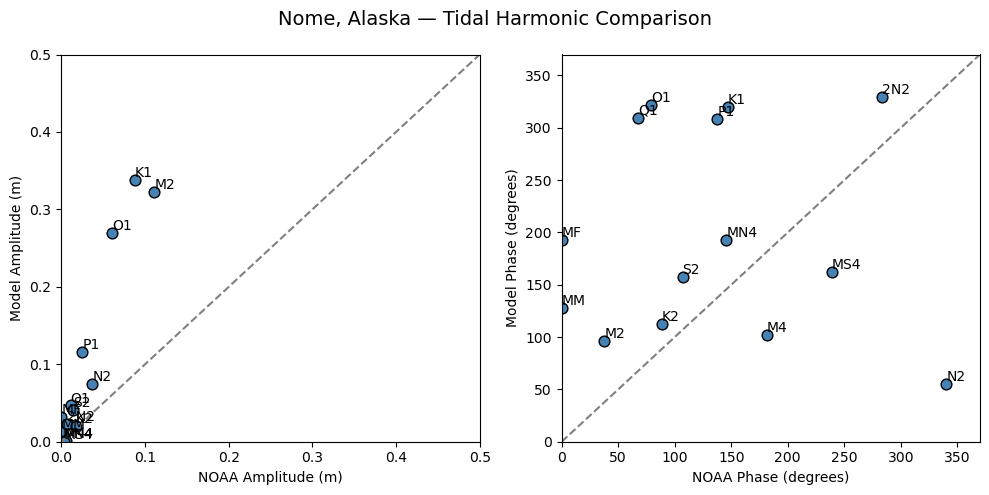

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
obs_harm = pd.read_csv(f'/scratch/tmiesse/project/noaa_data/{name}_noaa_constituents.csv')
model_amp, obs_amp = [], []
model_pha, obs_pha = [], []
# steelblue nome
# darkorange red dog
# seagreen prudhoe 
# mediumorchid unalakleet

# Scatter plot
color = "steelblue"
for i in range(len(keys)):
    amps = ncfile.variables['amp'][node_idx,i]
    phas = ncfile.variables['phs'][node_idx,i]
    oamps = obs_harm.loc[obs_harm['Constituent'] == keys[i],'Amplitude (m)'].values
    ophas = obs_harm.loc[obs_harm['Constituent'] == keys[i],'Phase (deg)'].values
    if len(oamps) > 0 and len(ophas) > 0:
        model_amp.append(amps)
        obs_amp.append(oamps[0])
        model_pha.append(phas)
        obs_pha.append(ophas[0])

        # Scatter with labels
        ax1.scatter(oamps, amps, color=color, edgecolor='k', s=60)
        ax2.scatter(ophas, phas, color=color, edgecolor='k', s=60)
        ax1.text(oamps[0], amps, keys[i], fontsize=10, ha='left', va='bottom')
        ax2.text(ophas[0], phas, keys[i], fontsize=10, ha='left', va='bottom')
lims_amps = [0, 0.5]
lims_pha = [0, 370]
ax1.plot(lims_amps, lims_amps, "--", color="gray")
ax2.plot(lims_pha, lims_pha, "--", color="gray")
ax1.set_xlim(lims_amps), ax1.set_ylim(lims_amps)
ax2.set_xlim(lims_pha), ax2.set_ylim(lims_pha)
ax2.set_ylabel("Model Phase (degrees)"),ax2.set_xlabel("NOAA Phase (degrees)")
ax1.set_ylabel("Model Amplitude (m)"),ax1.set_xlabel("NOAA Amplitude (m)")

plt.suptitle(f"{name.capitalize()}, Alaska — Tidal Harmonic Comparison", fontsize=14)
plt.tight_layout()
plt.savefig(f'/scratch/tmiesse/project/figures/{name}_harmonics.png',
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.show()